# Setting up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Emotion_Detection/Emotion-Detection-From-Tweets-Using-BERT-and-SVM-Ensemble-Model"

/content/drive/MyDrive/Emotion_Detection/Emotion-Detection-From-Tweets-Using-BERT-and-SVM-Ensemble-Model


In [ ]:
!pip install -qq sentencepiece
!pip install -qq transformers==4.7.0
!pip install -qq unidecode

In [ ]:
# !gdown --id -qq 1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
# !gdown --id -qq 141nsJ-dt-ZDR0aM1GkY2CGEmKeIM7O1F
# !gdown --id 1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
# !unzip -qq wassa_dataset.zip
# !rm wassa_dataset.zip

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import torch.utils
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
import re
import unidecode
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from transformers import MT5Tokenizer
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel, AlbertModel, AlbertTokenizer, AutoModel, AutoTokenizer

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3251707786.py", line 1, in <cell line: 0>
    import transformers
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1322, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1262, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1532, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1504, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1483, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceba

In [ ]:
nltk.download("all")

# Loading the dataset

In [ ]:
df_train = pd.read_csv("wassa_train.csv")
df_val = pd.read_csv("wassa_val.csv")
df_test = pd.read_csv("wassa_test.csv")
n_samples = df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()
print(n_samples)

In [ ]:
emotions_list=["joy", "anger", "fear", "sadness", "neutral"]

In [ ]:

texts_train = df_train.tweet.tolist()
texts_val = df_val.tweet.tolist()
texts_test = df_test.tweet.tolist()

label_encoder = LabelEncoder()
emotions_train = label_encoder.fit_transform(df_train.emotion.tolist())
emotions_val = label_encoder.transform(df_val.emotion.tolist())
emotions_test = label_encoder.transform(df_test.emotion.tolist())

#Preprocessing the dataset

In [ ]:
def preprocess_text(text_list):
  for i, text in enumerate(text_list):
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", text)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    text_list[i] = result

In [ ]:
preprocess_text(texts_train)
preprocess_text(texts_val)
preprocess_text(texts_test)

# Useful functions

In [ ]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")




# Model and tokenizer selection functions





In [ ]:
def get_model(model_name):
  model = None
  if model_name == 'bert-base-cased':
      model = BertModel.from_pretrained(model_name)

  if model_name == 'roberta-base':
      model = RobertaModel.from_pretrained(model_name)

  if model_name == 'vinai/bertweet-base':
      model = AutoModel.from_pretrained(model_name)

  return model

def get_tokenizer(model_name):
    tokenizer = None
    if model_name == 'bert-base-cased':
      tokenizer = BertTokenizer.from_pretrained(model_name)

    if model_name == 'roberta-base':
      tokenizer = RobertaTokenizer.from_pretrained(model_name)

    if model_name == 'vinai/bertweet-base':
      tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True, use_fast=False)

    return tokenizer

# Choosing the device and model

In [ ]:
!pip3 install emoji==0.6.0

In [ ]:
# this colab supports training for bert-base-cased roberta-base vinai/bertweet-base models
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = get_tokenizer(PRE_TRAINED_MODEL_NAME)
if tokenizer is None:
  print("Wrong model! Choose another one.")

In [ ]:
epoch_dict = {"bert-base-cased" : 5, "roberta-base":5, "vinai/bertweet-base":5}
maxlen_dict = {"bert-base-cased" : 85, "roberta-base":170, "vinai/bertweet-base":90}

In [ ]:
EPOCHS = epoch_dict[PRE_TRAINED_MODEL_NAME]
BATCH_SIZE = 16 # higher batch size might aid in the latter stages of fine tuning
maxlen = maxlen_dict[PRE_TRAINED_MODEL_NAME]
device = "cuda" if torch.cuda.is_available() else "cpu"

device

# Building the PyTorch datasets and dataloaders

In [ ]:
class WassaDataset(Dataset):

  def __init__(self, texts, emotions, tokenizer, max_len):
    self.texts = texts
    self.emotions = emotions
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    text = str(self.texts[item])
    emotion = self.emotions[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'emotions': torch.tensor(emotion, dtype=torch.long)
    }

In [ ]:
def create_data_loader(texts, emotions, tokenizer, max_len, batch_size):
  dataset = WassaDataset(
    texts=texts,
    emotions=emotions,
    tokenizer=tokenizer,
    max_len=max_len)

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
train_data_loader = create_data_loader(texts_train, emotions_train, tokenizer, maxlen, BATCH_SIZE)
val_data_loader = create_data_loader(texts_val, emotions_val, tokenizer, maxlen, BATCH_SIZE)
test_data_loader = create_data_loader(texts_test, emotions_test, tokenizer, maxlen, BATCH_SIZE)

# Building the model

In [ ]:
class EmotionsClassifier(nn.Module):
  def __init__(self, n_classes, model_name):
    super(EmotionsClassifier, self).__init__()
    self.bert = get_model(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [ ]:
model = EmotionsClassifier(len(emotions_list), PRE_TRAINED_MODEL_NAME)
model.to(device)

In [ ]:

# optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.NLLLoss().to(device)

# Training and validation

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    emotions = d["emotions"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, emotions)
    correct_predictions += torch.sum(preds == emotions)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      emotions = d["emotions"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, emotions)
      correct_predictions += torch.sum(preds == emotions)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(texts_train)
  )

  print(f'Training loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(texts_val)
  )

  print(f'Validation loss {val_loss} accuracy {val_acc}')
  print()

  # history['train_acc'].append(train_acc)
  # history['train_loss'].append(train_loss)
  # history['val_acc'].append(val_acc)
  # history['val_loss'].append(val_loss)
  history['train_acc'].append(train_acc.item())
  history['train_loss'].append(train_loss.item())
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss.item())


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

# Plotting training history

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# BERT_model Class





In [ ]:
class Bert_model:
  def __init__(self, model, encoder, tokenizer, maxlen):
    self._model = model
    self._encoder = encoder
    self._tokenizer = tokenizer
    self._device = "cpu"
    self._maxlen = maxlen

  def set_device(self, device):
    self._device = device
    self._model.to(device)

  def _preprocess_text(self, text):
      # eliminate URLs
      result = re.result = re.sub(r"http\S+", "", text)
      # eliminate email addresses
      result = re.sub('\S*@\S*\s?', '', result)
      return result

  def _make_prediction_for_text(self, text):
    text = self._preprocess_text(text)
    encoding = self._tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self._maxlen,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(self._device)
    attention_mask = encoding['attention_mask'].to(self._device)
    outputs = self._model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    outputs.to(self._device)
    return outputs.cpu().detach().numpy()

  def detect_emotions_with_labels(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion = self._make_prediction_for_text(text)
      pred = np.argmax(emotion, axis=1)
      prediction = self._encoder.inverse_transform(pred)
      predicted_emotions.append(prediction[0])
    return predicted_emotions

  def detect_emotions_with_proba(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion_proba = self._make_prediction_for_text(text)
      predicted_emotions.append(emotion_proba)
    return np.concatenate(predicted_emotions)

<>:17: SyntaxWarning: invalid escape sequence '\S'
<>:17: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-710182696.py:17: SyntaxWarning: invalid escape sequence '\S'
  result = re.sub('\S*@\S*\s?', '', result)


In [ ]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionsClassifier(len(emotions_list), PRE_TRAINED_MODEL_NAME)
model.load_state_dict(torch.load('best_model_state.bin',map_location=device))
model.to(device)
model.eval()

EmotionsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
bert_model = Bert_model(model, label_encoder, tokenizer, maxlen)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
bert_model.set_device(device)


## Bert model validation

In [ ]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_val)
y_true = label_encoder.inverse_transform(emotions_val)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.8986666666666666
, precision = 0.9002064638436819
, recall = 0.8986666666666666
, f1_score = 0.8991171342329768



## Bert model testing

In [ ]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_test)
y_true = label_encoder.inverse_transform(emotions_test)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.8813333333333333
, precision = 0.8822356438848654
, recall = 0.8813333333333334
, f1_score = 0.881412115469697



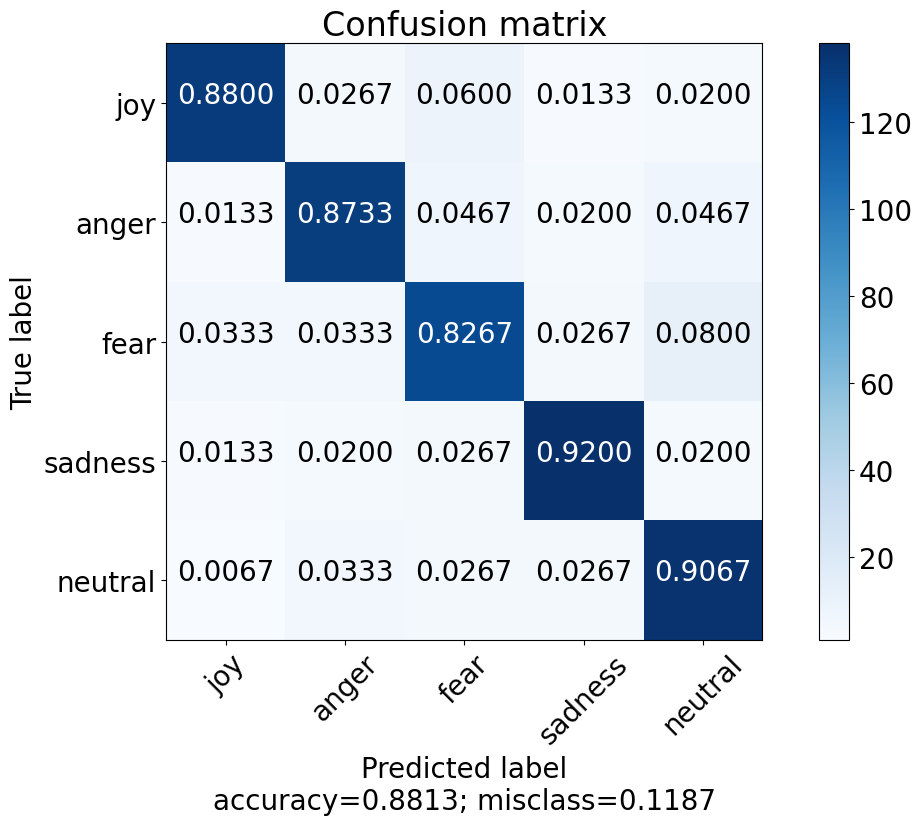

In [ ]:
cm = confusion_matrix(y_true, bert_predictions, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

In [ ]:
print(classification_report(y_true, bert_predictions))

              precision    recall  f1-score   support

       anger       0.89      0.87      0.88       150
        fear       0.84      0.83      0.83       150
         joy       0.93      0.88      0.90       150
     neutral       0.84      0.91      0.87       150
     sadness       0.91      0.92      0.92       150

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750



# Building the ensemble model

## Adding the SVM model to the ensemble model

In [ ]:
class SVM_model:
  def __init__(self, classifier, encoder, stop_words, vectorizer):
    self._classifier = classifier
    self._encoder = encoder
    self._stop_words = stop_words
    self._vectorizer = vectorizer

  def _preprocess_text(self, text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")
    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "
    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

  def _vectorize_texts(self, texts):
    vectorized_texts = []
    for text in texts:
      processed_text = self._preprocess_text(text, self._stop_words)
      vectorized_texts.append(processed_text)
    return self._vectorizer.transform(vectorized_texts)

  def detect_emotions_with_labels(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    predictions  = list(self._encoder.inverse_transform(np.argmax(predictions, axis=1)))
    return predictions

  def detect_emotions_with_proba(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    return predictions

  def proba_to_labels(self, proba):
      labels  = list(self._encoder.inverse_transform(np.argmax(proba, axis=1)))
      return labels

<>:16: SyntaxWarning: invalid escape sequence '\S'
<>:16: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-1222258803.py:16: SyntaxWarning: invalid escape sequence '\S'
  result = re.sub('\S*@\S*\s?', '', result)


In [ ]:
svm_model = pickle_load_object("svm_model.obj")

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

##   Ensemble model test (No stacking)

In [ ]:
bert_predictions = bert_model.detect_emotions_with_proba(texts_test)
svm_predictions = svm_model.detect_emotions_with_proba(texts_test)
# combine results for the ensemble model
predictions = svm_predictions+bert_predictions

In [ ]:
y_true = label_encoder.inverse_transform(emotions_test)

In [ ]:
# get labels from ensemble model
predicted_emotions_inv = svm_model.proba_to_labels(predictions)

In [ ]:
acc = accuracy_score(y_true, predicted_emotions_inv)
acc

0.9173333333333333

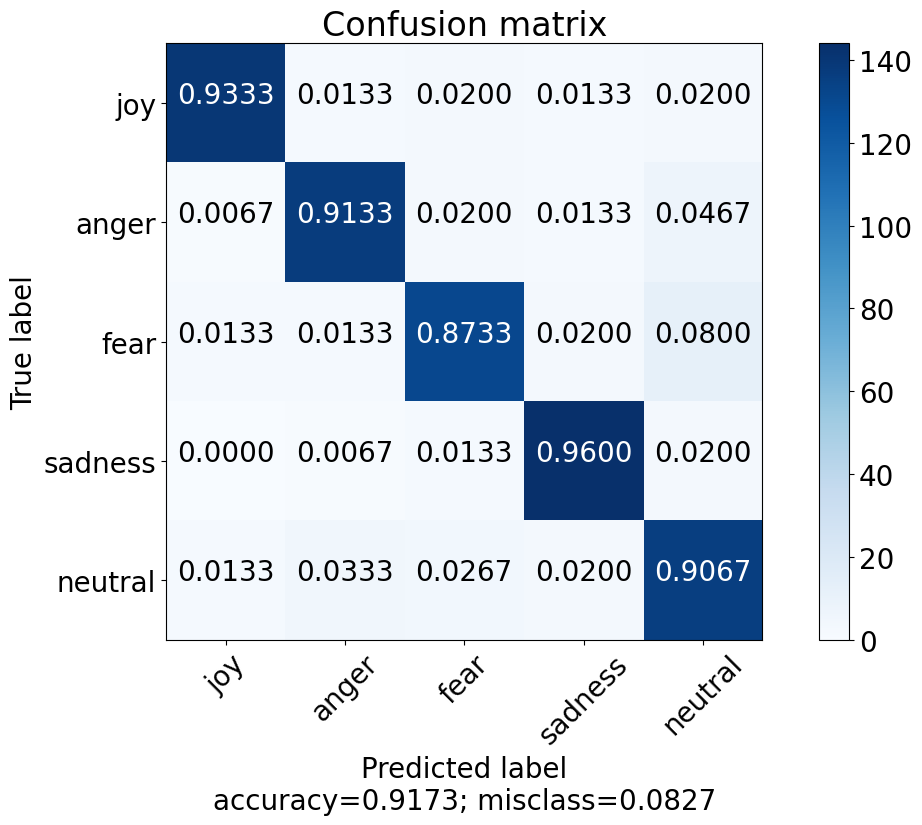

In [ ]:
cm = confusion_matrix(y_true, predicted_emotions_inv, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

In [ ]:
print(classification_report(y_true, predicted_emotions_inv))

              precision    recall  f1-score   support

       anger       0.93      0.91      0.92       150
        fear       0.92      0.87      0.89       150
         joy       0.97      0.93      0.95       150
     neutral       0.84      0.91      0.87       150
     sadness       0.94      0.96      0.95       150

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750



## Ensemble model class

In [ ]:
class Ensemble_Model:
  def __init__(self, bert_model, svm_model):
    self._bert_model = bert_model
    self._svm_model = svm_model

  def set_bert_device(self, device):
    self._bert_model.set_device(device)

  def detect_emotions(self, texts):
    svm_predictions = self._svm_model.detect_emotions_with_proba(texts)
    bert_predictions = self._bert_model.detect_emotions_with_proba(texts)
    predictions = svm_predictions+bert_predictions
    return self._svm_model.proba_to_labels(predictions)


In [ ]:
en_model = Ensemble_Model(bert_model, svm_model)

In [ ]:
en_model.set_bert_device("cpu")

In [ ]:
predictions = en_model.detect_emotions(texts_test)

In [ ]:
acc = accuracy_score(df_test.emotion.tolist(), predictions)
acc

0.9173333333333333

In [ ]:
pickle_object(en_model, "english_model.obj")

In [ ]:
predictions = en_model.detect_emotions(["I am sitting home", "New York is a big city", "The president has arrived"])
predictions

[np.str_('neutral'), np.str_('neutral'), np.str_('fear')]

### Combine Ensemble with Stacking

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# ===== VALIDATION =====
bert_val_prob = bert_model.detect_emotions_with_proba(texts_val)  # (N, C)
svm_val_prob  = svm_model.detect_emotions_with_proba(texts_val)   # (N, C)

# concat
X_meta_val = np.hstack([bert_val_prob, svm_val_prob])
y_meta_val = emotions_val


In [ ]:
scaler = StandardScaler()
X_meta_val = scaler.fit_transform(X_meta_val)


In [ ]:
meta_clf = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    multi_class="auto"
)

meta_clf.fit(X_meta_val, y_meta_val)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto')

In [ ]:
bert_test_prob = bert_model.detect_emotions_with_proba(texts_test)
svm_test_prob  = svm_model.detect_emotions_with_proba(texts_test)

X_meta_test = np.hstack([bert_test_prob, svm_test_prob])
X_meta_test = scaler.transform(X_meta_test)

meta_preds = meta_clf.predict(X_meta_test)

final_preds = label_encoder.inverse_transform(meta_preds)
y_true = label_encoder.inverse_transform(emotions_test)


In [ ]:
acc = accuracy_score(y_true, final_preds)
print("Stacking Accuracy:", acc)

print(classification_report(y_true, final_preds))


Stacking Accuracy: 0.924
              precision    recall  f1-score   support

       anger       0.99      0.91      0.94       150
        fear       0.92      0.89      0.90       150
         joy       0.96      0.95      0.96       150
     neutral       0.83      0.93      0.88       150
     sadness       0.94      0.94      0.94       150

    accuracy                           0.92       750
   macro avg       0.93      0.92      0.92       750
weighted avg       0.93      0.92      0.92       750

